In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import itertools
import matplotlib


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from tqdm import tqdm
from copy import copy
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

matplotlib.rcParams.update({'font.size': 13})
plt.style.use("ggplot")

In [84]:
#
# Load the data from pickled class created in "dataset_parser"
#

# data = pickle.load(open("dataset_alphabay.p","rb"))
# data = pickle.load(open("dataset_poseidon.p","rb"))
# data = pickle.load(open("dataset_poseidon_nocheat.p","rb"))
data = pickle.load(open("dataset_alphabay_nocheat.p","rb"))

pprint(data[0].keys())

[u'category', u'description']


In [85]:
#
# Construct the data - X and Y (input/output)
#
description = [x.get("description") for x in data]
category = [x.get("category").split("/")[0] for x in data]
category_subs = [x.get("category") for x in data]

# remove other listing
# for _ in [1,2]: 
#     for i,x in enumerate(category):
#         if u'OtherListings' in x:
#             category.pop(i)
#             description.pop(i)    

In [214]:
#
# Oversampling
#

def oversample(di, cat, nr):
    tmp=[]
    for x in range(nr):
        new = di.get(cat)[x%len(di.get(cat))]
        tmp.append(new)
        
    di[cat] = di.get(cat) + tmp

In [360]:

max_sample = max([[x, category.count(x)] for x in set(category)], key=lambda x: x[1])[1]
print(max_sample)

#
# Add al description to a dictionary
#

di = {}
for c,d in zip(category, description):
    try:
        di.get(c).append(d)
    except:
        di[c] = []
        di.get(c).append(d)

for x in di.keys():
    if len(di.get(x)) <= max_sample:
        oversample(di, x, max_sample-len(di.get(x)))
        
category = []
description = []

for x in di.keys():
    description += di.get(x)
    category += [x]*len(di.get(x))

print(len(category))
print(len(description))

2222
24442
24442


In [6]:
# #
# # Print the distribution between the categories
# #

# main_c = []
# data2 = di

# # for x in data.items():
# #     try:
# #         data2[x[0].split("/")[0]] += x[1]
# #     except:
# #         data2[x[0].split("/")[0]] = x[1]

# d_key = [k for k in sorted(data2, key=lambda k: data2[k], reverse=True)]
# d_val = [data2.get(k) for k in d_key]

# fig = plt.figure()
# plt.bar(range(len(data2)), d_val, align='center')
# plt.xticks(range(len(data2)), d_key)
# fig.autofmt_xdate()
# plt.xlabel("Product category")
# plt.ylabel("Number of web pages")
# plt.show()

In [7]:
### FOR ANOMALY DETECTION

def anom():
    weapon = [x for x in category if u'Weapons' in x]
    weapon_binary = [u'Weapons' in x for x in category]

    print "weapons:", len(weapon), "("+str(len(weapon))+")"
    print float(len(weapon))/float(len(category)-len(weapon))*100, "% weapons"

    w_description = []
    nw_category = copy(category)
    nw_description = copy(description)

    for _ in [1,2]: # remove this for 
        for i,x in enumerate(nw_category):
            if u'Weapons' in x:
                w_description.append(nw_description[i])
                nw_category.pop(i)
                nw_description.pop(i)
                
    return weapon, weapon_binary, w_description, nw_category, nw_description

# weapon, weapon_binary, w_description, nw_category, nw_description = anom()

In [8]:
# 
# Removing non-english
#
def language_eng():
    from langdetect import detect,detect_langs
    global category
    global description

    for dt in tqdm(data):
        if detect(dt.get("description")) != "en":
            continue
        description.append(dt.get("description"))
        category.append(dt.get("category").split("/")[0])

In [9]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [176]:
# #
# # count vectoriser - 
# # Ret: matrix containing occurance of word in document 
# #
# # print(X_train_counts) 
# #   (document, word_id, occurances)
# #   (0, 5976)	2
# #   (0, 15089)	1
# #   (0, 7283)	1
# #
# def count_word_matrix():
#     global X_train_counts
#     count_vect = CountVectorizer(tokenizer=LemmaTokenizer()) #stop_words = 'english', min_df=0.0008
#     X_train_counts = count_vect.fit_transform(description)
#     print(X_train_counts.shape)
    
# # count_word_matrix()

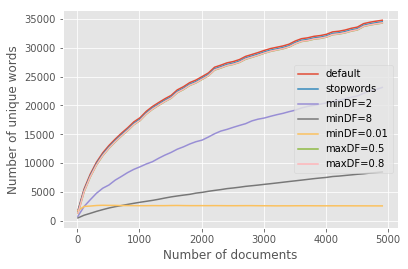

In [87]:
cv = []
cv.append((CountVectorizer(),'default'))
cv.append((CountVectorizer(stop_words='english'),'stopwords'))
cv.append((CountVectorizer(min_df=2),'minDF=2'))
cv.append((CountVectorizer(min_df=8),'minDF=8'))
cv.append((CountVectorizer(min_df=0.01),'minDF=0.01'))
cv.append((CountVectorizer(max_df=0.5),'maxDF=0.5'))
cv.append((CountVectorizer(max_df=0.8),'maxDF=0.8'))


res = [[] for _ in range(len(cv))]
rangen = range(10,5000, 100)

for i in rangen:
    x = description[:i]
    for ind, (cv_,lb) in enumerate(cv):
        feat = cv_.fit_transform(x).shape[1]
        res[ind].append(feat)

plt.xlabel("Number of documents")
plt.ylabel("Number of unique words")

for ind, res_ in enumerate(res):
    plt.plot(rangen, res_, label=cv[ind][1])

plt.legend()
plt.plot()
plt.show()

In [10]:
from sklearn.decomposition import SparsePCA

t_v = TfidfVectorizer(use_idf=False)
feat = t_v.fit_transform(description[:100])

print("Feature:",feat.shape)

spca = SparsePCA(n_components=3)
t_feat = spca.fit_transform(feat.toarray())

('Feature:', (100, 1412))


In [6]:
# print(t_feat)

In [88]:
#
# TFIDF w/o using countvectorizer (Equivalent to CountVectorizer + TfidfTransformer)
#
def tfidf(inp):
    tfidf_transformer = TfidfVectorizer(use_idf=True,
                                        stop_words='english',
                                        min_df=10,
                                        max_df=0.4)
    
    return tfidf_transformer.fit_transform(inp)
    
X_tfidf = tfidf(description)

print(X_tfidf.shape)

(53504, 35093)


In [169]:
#
# Hashing vectorizer
#
def tfidf(inp):
    hash_v = HashingVectorizer(stop_words='english')
    return hash_v.fit_transform(inp)

X_hash = tfidf(description)
# X_train_tfidf_w = tfidf(w_description)
# X_train_tfidf_nw = tfidf(nw_description)

# tsvm = TruncatedSVD(n_components=100)
# tsvm.fit(X_train_tfidf)
# X_train_tfidf = tsvm.transform(X_train_tfidf)
# X_train_tfidf_nw = tsvm.transform(X_train_tfidf_nw)
# X_train_tfidf_w = tsvm.transform(X_train_tfidf_w)

print(X_hash.shape)    

(5583, 1048576)


In [ ]:
#
# Problem and target 
#
problem = category
input_data = X_tfidf
y_ = [list(set(problem)).index(x) for x in problem]

In [ ]:
#
# clf = list of estimators
#

# pca = TruncatedSVD(n_components=3)
# pca.fit(X_tfidf)
# input_data_10 = pca.transform(X_tfidf)
# print("dmi_red_done")

X_train, X_test, y_train, y_test = train_test_split(input_data, y_, test_size=0.33)

clf = VotingClassifier([('SVC_rbf',SVC()), 
                        ('Naibe_B',sklearn.naive_bayes.BernoulliNB()),
                        ('SVC_linear', sklearn.svm.LinearSVC()),
                        ('Ridge',sklearn.linear_model.RidgeClassifier()),
                        ('KNN',sklearn.neighbors.KNeighborsClassifier()),
                        ('SGD',SGDClassifier())])

clf.fit(X_train, y_train)
clf.score(X_test, y_test)
# clf350 = clf
# clf75 = clf
# clf3 = clf
# clf4249 = clf
# clf10 = clf

In [ ]:
#
# Plot result of multiple classifiers (clfs)
#
matplotlib.rcParams.update({'font.size': 16})

def plot_clfs(clf_list, names):
    fig = plt.figure(figsize=(10,7))

    for ind, clf_ in enumerate(clf_list):
        inp = input_data
#         if ind==0:
#             inp = input_data_3
#         if ind==1:
#             inp = input_data_10
#         if ind==2:
#             inp = input_data_75
#         if ind==3:
#             inp = input_data_350
#         if ind==4:
#             inp = input_data
        
        X_train, X_test, y_train, y_test = train_test_split(inp, y_)
        
        clf_count = np.arange(len(clf_.estimators))
        clf_scores = [est.score(X_test, y_test) for est in clf_.estimators_]
        clf_names = [n[0] for n in clf_.estimators]
        plt.bar(clf_count+0.8*ind, clf_scores, width=0.8, label=names[ind])

        plt.xticks(clf_count, clf_names)
        
    fig.autofmt_xdate()
    plt.legend()
    plt.ylim([0,1])
    plt.xlabel("Estimator")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()

plot_clfs([clf], ['Default'])
# plot_clfs([clf3, clf10, clf75, clf350, clf4249], ['3','10', '75','350','4249'])
# plot_clfs([clf_idf, clf_over], ['Normal', 'Oversample'])


In [ ]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})
    
# X_train, X_test, y_train, y_test = train_test_split(input_data, y_, test_size=0.33)
# X_test = X_tfidf
# y_test = y_

class_names = list(set(problem))

# clf = sklearn.svm.LinearSVC(penalty='l1', dual=0, multi_class='crammer_singer').fit(X_train, y_train)
# clf = SGDClassifier().fit(X_train, y_train)

classifier = clf.estimators_[4]

print("Accuracy:",classifier.score(X_test, y_test))
y_pred = classifier.predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):

    cmap=plt.cm.Blues
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() * 0.85
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] < 0.01:
            continue
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18,12)

# Plot non-normalized confusion matrix
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18, 12)

# Plot normalized confusion matrix
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# input_data = [X]
X_train, y_train = X_train_tfidf_nw, nw_category
X_train, y_train = X_train_tfidf_w, weapon

X_test, y_test = X_train_tfidf, category
X_test_w, y_test_w = X_train_tfidf_w, weapon
X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

clf = OneClassSVM()
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':np.arange(0,1,0.1), 'nu':np.arange(0.01,1,0.1)}
outl = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1)

outl.fit(X_train, y_train)

# ----
inliers = float(outl.predict(X_test).tolist().count(1))/len(y_test)*100
print("Inliers (All): {}%".format(round(inliers,1)))

inliers = float(outl.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
print("Inliers (Weapons): {}%".format(round(inliers,1)))

inliers = float(outl.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

print(outl.best_estimator_)

In [ ]:
X_train, y_train = X_train_tfidf_w, weapon

X_test, y_test = X_train_tfidf, category
X_test_w, y_test_w = X_train_tfidf_w, weapon
X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

# be = OneClassSVM()
# be = OneClassSVM(nu=0.01, gamma=0.15, kernel='linear')
be = IsolationForest()
# be = GaussianMixture(n_components=33)
# be = KernelDensity()


be.fit(X_train, y_train)

inliers = float(be.predict(X_test).tolist().count(1))/len(y_test)*100
print("Inliers (All): {}%".format(round(inliers,1)))

inliers = float(be.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
print("Inliers (Weapons): {}%".format(round(inliers,1)))

inliers = float(be.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier().fit(X_train, y_train)
print("Accuracy:",clf.score(X_test,y_test))

from pandas import DataFrame
col = []
for i, da in enumerate(y_test):
    if b'Wea' in da:
        pred_y = clf.predict(X_test[i])[0]
        ol = 1!=outl.predict(X_test[i])[0]
        col.append([da,pred_y,ol])

df = DataFrame(col,columns=["Y_true","Y_predicted","outlier"])
print(df.loc(df["outlier"]==True))

In [ ]:
print("Hits:",df.shape[0])
print("Wrong pred:",df.loc[df["Y_true"]!=df["Y_predicted"]].shape[0])
print("Correct pred:",df.loc[df["Y_true"]==df["Y_predicted"]].shape[0])
print("Outliers:",df.loc[df["outlier"]==1].shape[0])
print("Outliers & wrong prediction:",df.loc[df["outlier"]==1][df["Y_true"]!=df["Y_predicted"]].shape[0])
df.loc[df["Y_true"]!=df["Y_predicted"]]

In [ ]:
# ii=0
# for i,x in enumerate(y_test):
# #     if b'Weapon' in x:
# #         print(i,x,"Outlier:",clf.predict(X_test[i])==True)
# #         ii+=1
#     if clf.predict(X_test[i]):
#         ii+=1
        
# print(ii)
# print(len(y_test))
# print(ii/len(y_test),"inliers")

In [ ]:
#
# reduce dimension
# Input: out dimension size - eg. 3
# Out:   X
#

def red_dimen(inp, to):
    pca = TruncatedSVD(n_components=to)
    pca.fit(input_data)
    X = pca.transform(inp)
#     X = inp.toarray()
#     pca = PCA(n_components=to)
#     pca.fit(X)
#     X = pca.transform(X)
    return X

In [ ]:
#
# Plot X (3D)  
# Input: X (global)
#
X = red_dimen(X_tfidf, 3)

def plot_data():

    %matplotlib inline
    #inline, gtk, osx, tk, empty uses defaultgtk

    fig = plt.figure(1, figsize=(10, 8))
    ax = Axes3D(fig)

    y = problem

    for name, label in zip(list(set(problem)), list(set(y))):
#         if "outlier" in str(name):# or u'Jewels&Gold' in name or u'Services' in name or u'Software&Malware' in name:
#             continue
        ax.scatter(X[[label==t for t in y], 0], 
                  X[[label==t for t in y], 1],
                  X[[label==t for t in y], 2], label=name, s=6)
    #     ax.text3D(X[[label==t for t in y], 0].mean(),
    #               X[[label==t for t in y], 1].mean(),
    #               X[[label==t for t in y], 2].mean(), name)          

    plt.legend(loc='upper right', ncol=2)
    ax.set_xlabel('PCA 0')
    ax.set_ylabel('PCA 1')
    ax.set_zlabel('PCA 2')
    plt.show()
    
plot_data()

In [ ]:
# #
# # Plot X (3D)  
# # Input: X (global)
# #

# X = red_dimen(X_tfidf, 3)

# outl = GaussianMixture(n_components=2)
# outl.fit(X)
# outliers = outl.score_samples(X)

# def plot_data():
#     %matplotlib inline
#     #inline, gtk, osx, tk, empty uses defaultgtk
#     fig = plt.figure(1, figsize=(10, 8))
#     ax = Axes3D(fig)
#     ax.scatter(X[:, 0], X[:, 1], outliers, s=2, c=y_)
#     ax.set_xlabel('X axis - PCA 0')
#     ax.set_ylabel('Y axis - PCA 1')
#     ax.set_zlabel('Weighted log probabilities')
#     plt.show()
    
# plot_data()

In [ ]:
#
# Plot X (2D)  
# Input: X2d (global)
#

X2d = red_dimen(X_tfidf, 2)
    
def plot_data():
    %matplotlib inline
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, s=10)
        
#         plt.text(X2d[[name==t for t in y], 0].mean(),
#                  X2d[[name==t for t in y], 1].mean(),
#                  name)

    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(loc='upper right', ncol=2)
    plt.show()
    
plot_data()

In [ ]:
# inp_data = X_tfidf
# pca2 = PCA(n_components=2500)
pca2 = TruncatedSVD(n_components=3500)
pca2.fit(X_tfidf)

#
# Scree plot
#
plt.ylabel("Variance")
plt.xlabel("Components")
plt.ylim(0)
plt.text(1,0.85,"Number of components\n"+str(X_tfidf.shape[1]))
var_rat = np.cumsum(pca2.explained_variance_ratio_)
var = np.cumsum(pca2.explained_variance_)
plt.plot(var_rat, label="cumulative variance ratio", c='r') #marker='o',
plt.plot(var, label="cumulative variance",c='b') #,marker='o'
plt.legend(loc='lower right')
plt.show()


In [ ]:
# ----
# print pca.explained_variance_
# sort_w = pca.components_[0].sort()

plt.ylabel("Variance ratio")
plt.xlabel("components in single value decomposition")
cumulative = np.cumsum(pca.explained_variance_ratio_)

# plt.plot(pca.explained_variance_, label="variance")
# plt.plot(pca.explained_variance_ratio_, label="variance ratio")
plt.plot(cumulative, label="cumulative variance ratio")
plt.legend()

plt.show()